# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present; # 90% RECALL TP / (TP + FN)
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant). # (TP/(TP+FP)) >= 80; 1 - FP/ TP+FP <= 20

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [27]:
# This code imports some libraries that you will need.
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time
import collections

# Pandas for overview
import pandas as pd
import random
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
# mpl.rc('axes', labelsize=7)
# mpl.rc('xtick', labelsize=6)
# mpl.rc('ytick', labelsize=6)
# mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

In [28]:
# set random seed for all instances of random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

### Loading in the Dataset

In [2]:
df = pd.read_csv(r"./assignment2_data_2024.csv")
df.head()

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
0,malignant,15.494653829645529,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,0.653654,1.096678,4.962255,80.619370,0.006669,0.034950,0.043568,0.013765,0.024093,0.004928
1,malignant,16.229870799611437,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,0.445451,1.043931,3.005373,50.407958,0.006352,0.019998,0.025324,0.012172,0.018084,0.003582
2,malignant,16.34567074196476,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,0.549625,1.057447,3.643671,62.732851,0.006757,0.031325,0.034350,0.015150,0.021459,0.004066
3,maligant,13.001009157806651,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,0.430693,1.202955,3.051434,33.614356,0.007930,0.044881,0.042972,0.014556,0.035670,0.005981
4,malignant,16.416060073302194,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,0.525532,1.045900,3.747194,59.164555,0.008718,0.024231,0.039763,0.014202,0.019236,0.004115


In [3]:
# Extract feature and labels names
feature_names = df.columns[1:]
target = df.columns[0]

### Preliminary Visualization of the Dataset

In [4]:
# Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         220 non-null    float64
 7   mean concavity           220 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            220 non-null    float64
 10  mean fractal dimension   220 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            220 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area error               2

We will first do a preliminary describe with the dirty data and after we clean these values, we can visualize the dataset again. (This will be done in step 2)

In [5]:
# Describe to show the statistics of the data
df.describe()

,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,219.000000,220.000000
mean,18.991963,89.866240,620.956227,0.096480,0.102879,0.085281,0.046867,0.181850,0.103957,0.393337,1.217593,2.775090,37.781034,0.007076,0.025514,0.031901,0.011762,0.020901,0.003873
std,1.427635,7.366180,106.419871,0.004961,0.019819,0.026911,0.012548,0.010816,0.606979,0.075828,0.210182,0.579317,9.988655,0.001043,0.007345,0.014102,0.002422,0.003250,0.001259
min,15.349270,74.690886,-2.645499,0.084651,0.075184,0.050771,0.028701,0.157059,0.058922,0.298005,0.898026,2.059186,27.693748,0.004994,0.016907,0.018730,0.007253,0.016181,0.002631
25%,17.914319,84.911981,558.731832,0.092797,0.089531,0.066525,0.038106,0.174944,0.061139,0.343114,1.073344,2.394331,31.843894,0.006372,0.020530,0.025373,0.010336,0.018658,0.003225
50%,18.928256,88.587737,603.806128,0.096457,0.098517,0.075748,0.042761,0.180953,0.062557,0.367863,1.165727,2.610732,34.007608,0.006837,0.023147,0.028835,0.011357,0.020193,0.003555
75%,19.995859,93.066393,655.690435,0.099817,0.113276,0.098826,0.055337,0.186354,0.064184,0.420514,1.300769,3.003888,39.042484,0.007675,0.027733,0.033620,0.012669,0.022195,0.004046
max,24.430831,121.247839,1103.740620,0.113423,0.192880,0.201971,0.100467,0.226448,9.065897,0.712896,2.561348,5.903661,80.619370,0.011088,0.054950,0.163592,0.026554,0.041861,0.013251


Visualize the distribution of each numerical feature:

**Using density plots**

/var/folders/gg/27ydp9614p9cpq8pg5r7rklc0000gn/T/ipykernel_27669/2683962586.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x = feature, hue = "label")


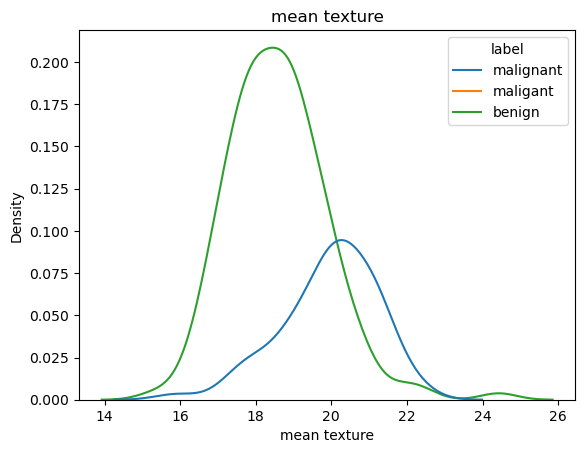

In [6]:
for feature in feature_names[1:]:
    sns.kdeplot(data = df, x = feature, hue = "label")
    plt.title(feature)
    plt.show()
    break

We notice that the label (target) data is dirty, we will first clean all the data, and then visualize the cleaned data.

### Data and Error handling

From the earlier point, we will clean the label (target) data.

In [7]:
# identify which are the erroneous values
df['label'].value_counts()

label
benign       154
malignant     65
maligant       1
Name: count, dtype: int64

In [8]:
# cleaning and inspecting the new label data
df['label'] = df["label"].str.replace("maligant","malignant")
df['label'].value_counts()

label
benign       154
malignant     66
Name: count, dtype: int64

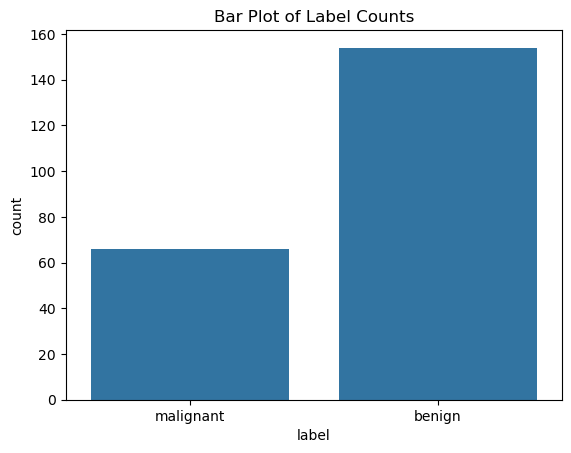

In [9]:
# bat plot of label to show target split
sns.countplot(data = df, x = "label")
plt.title('Bar Plot of Label Counts')
plt.show()

We notice that the column "mean radius" of not dtype float64, but an object. To know why, we will look look for the data that's not a number.

In [10]:
# Check for non-numeric numbers in "mean radius" column
for x in df["mean radius"].value_counts().index:
    if x.replace(".", "").isdigit() == False:
        print(x)

-14.292182467715936
n12.254518716420597


It can be seen that there are input errors and a negative value. Since the value is mean radius (a distance), it is impossible for the values to be negative.

In [11]:
df["mean radius"] = df["mean radius"].apply(lambda x: float(x[1:]) if ('-' in x) or ('n' in x) else float(x))
df["mean radius"]

0      15.494654
1      16.229871
2      16.345671
3      13.001009
4      16.416060
         ...    
215    13.618925
216    14.048464
217    12.879033
218    14.411991
219    12.704174
Name: mean radius, Length: 220, dtype: float64

We then check for null values in the data.

In [12]:
# Check for null values in the dataset
df.isnull().sum()

label                      0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             1
fractal dimension error    0
dtype: int64

In [13]:
df[df["symmetry error"].isna()]

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
218,benign,14.411991,18.970674,93.423809,671.128126,0.086304,0.090118,0.070882,0.039482,0.175789,...,0.356964,1.030049,2.56017,35.435273,0.005784,0.022279,0.025244,0.00999,NaN,0.003255


Note: Imputation will be part of the preprocessing pipeline to account for data leakage.

### Visualization and Outlier Analysis

#### Visualization of data distirbutions

**Using density plots**

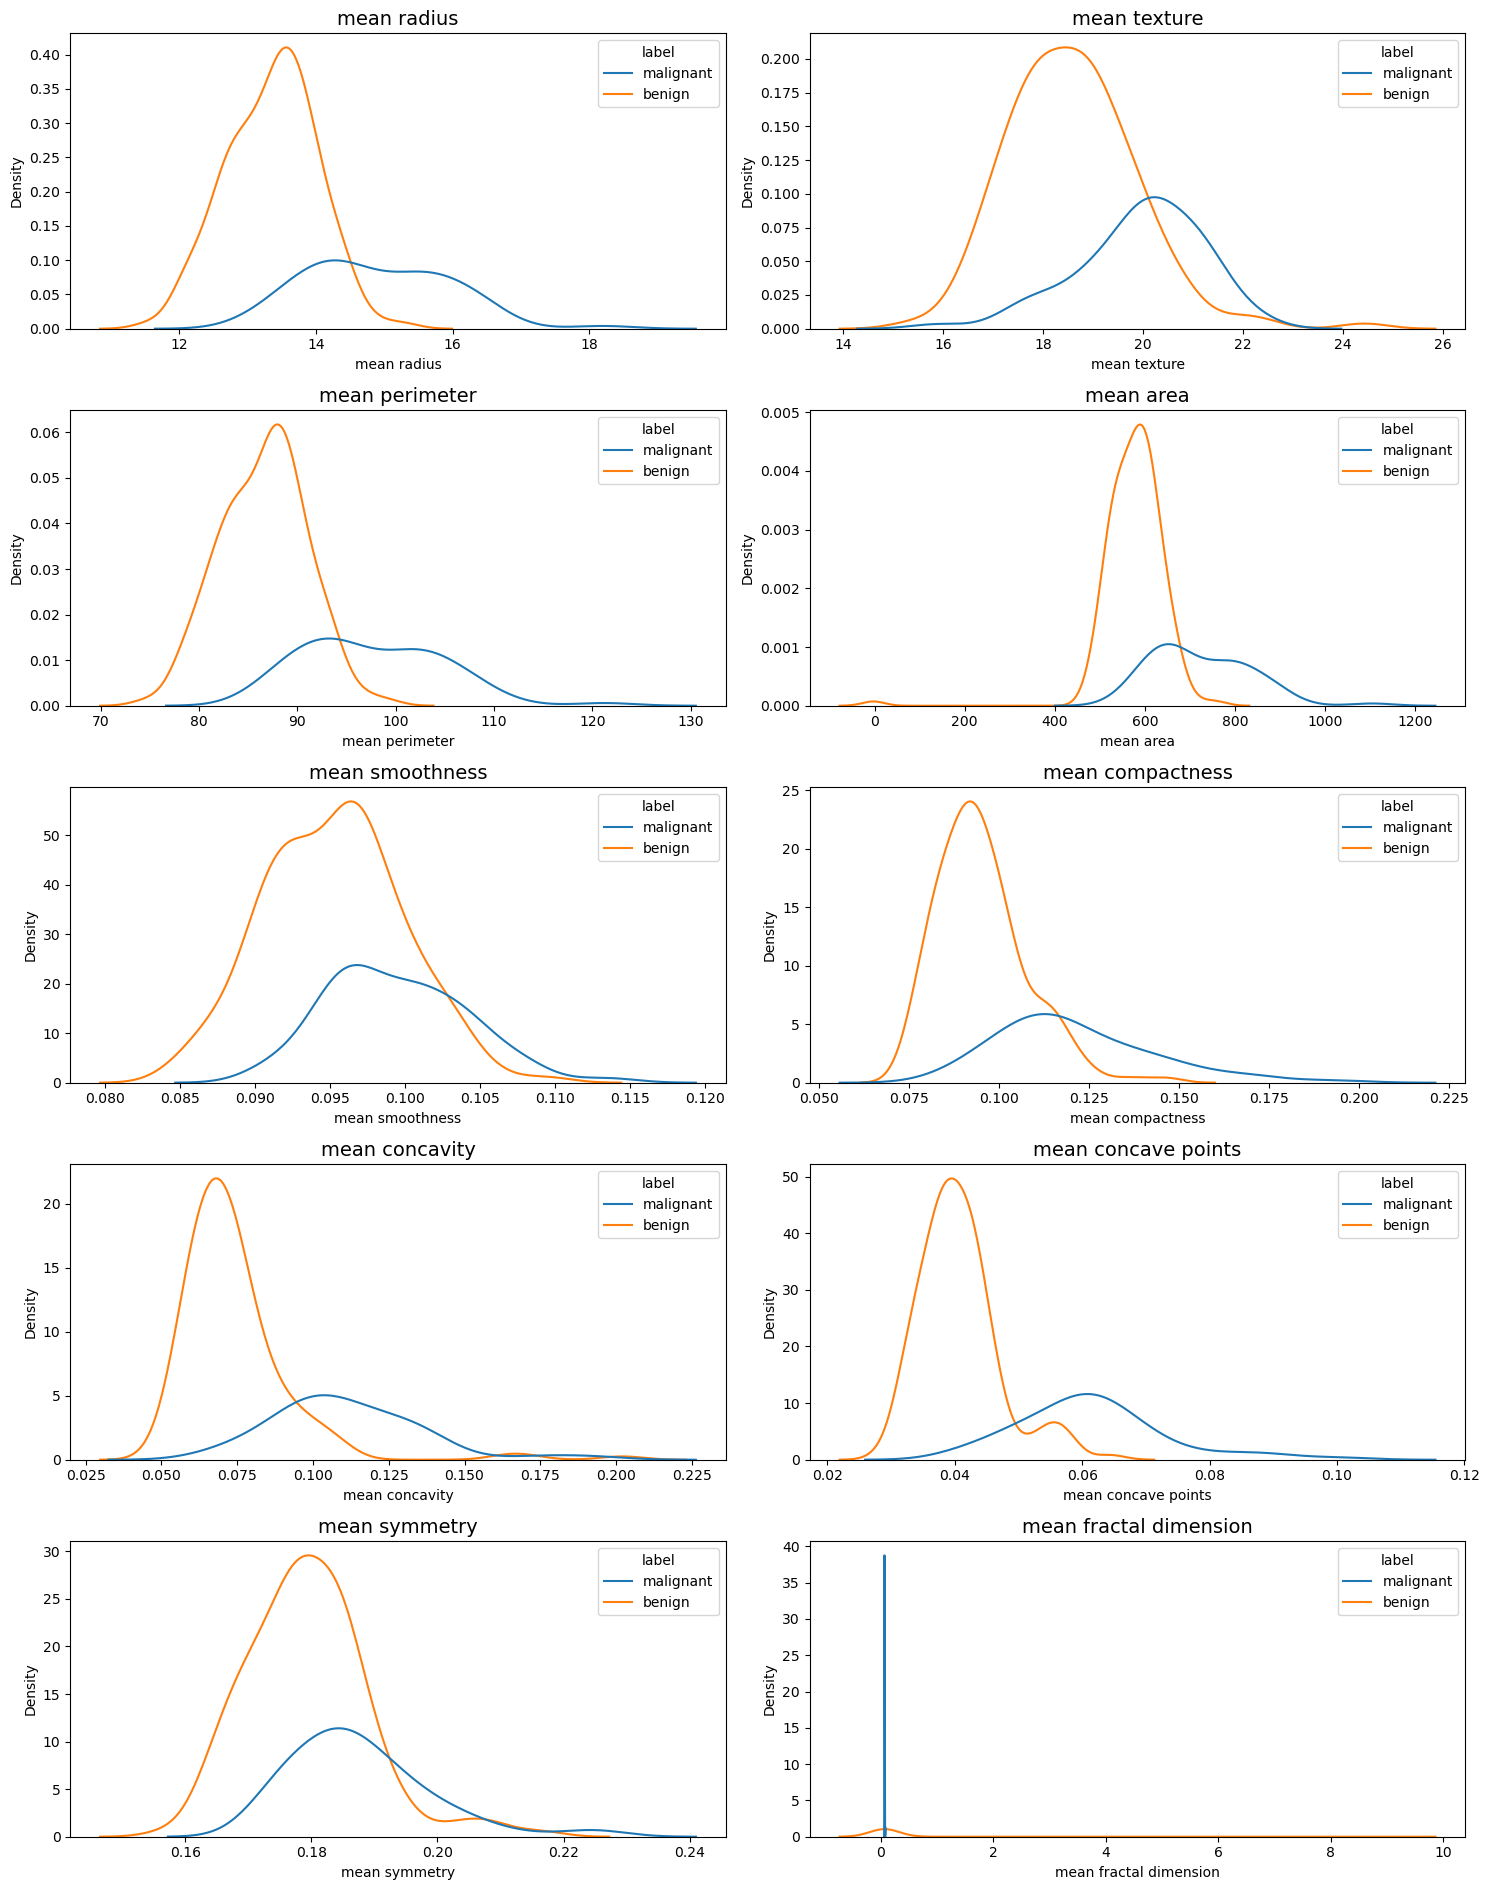

In [14]:
# Create subplots of mean features
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the figure size as needed

# Plotting the subplots
for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    ax = sns.kdeplot(data=df, x=v, hue="label", ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(v, fontsize=14)  # Adjust title font size as needea


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

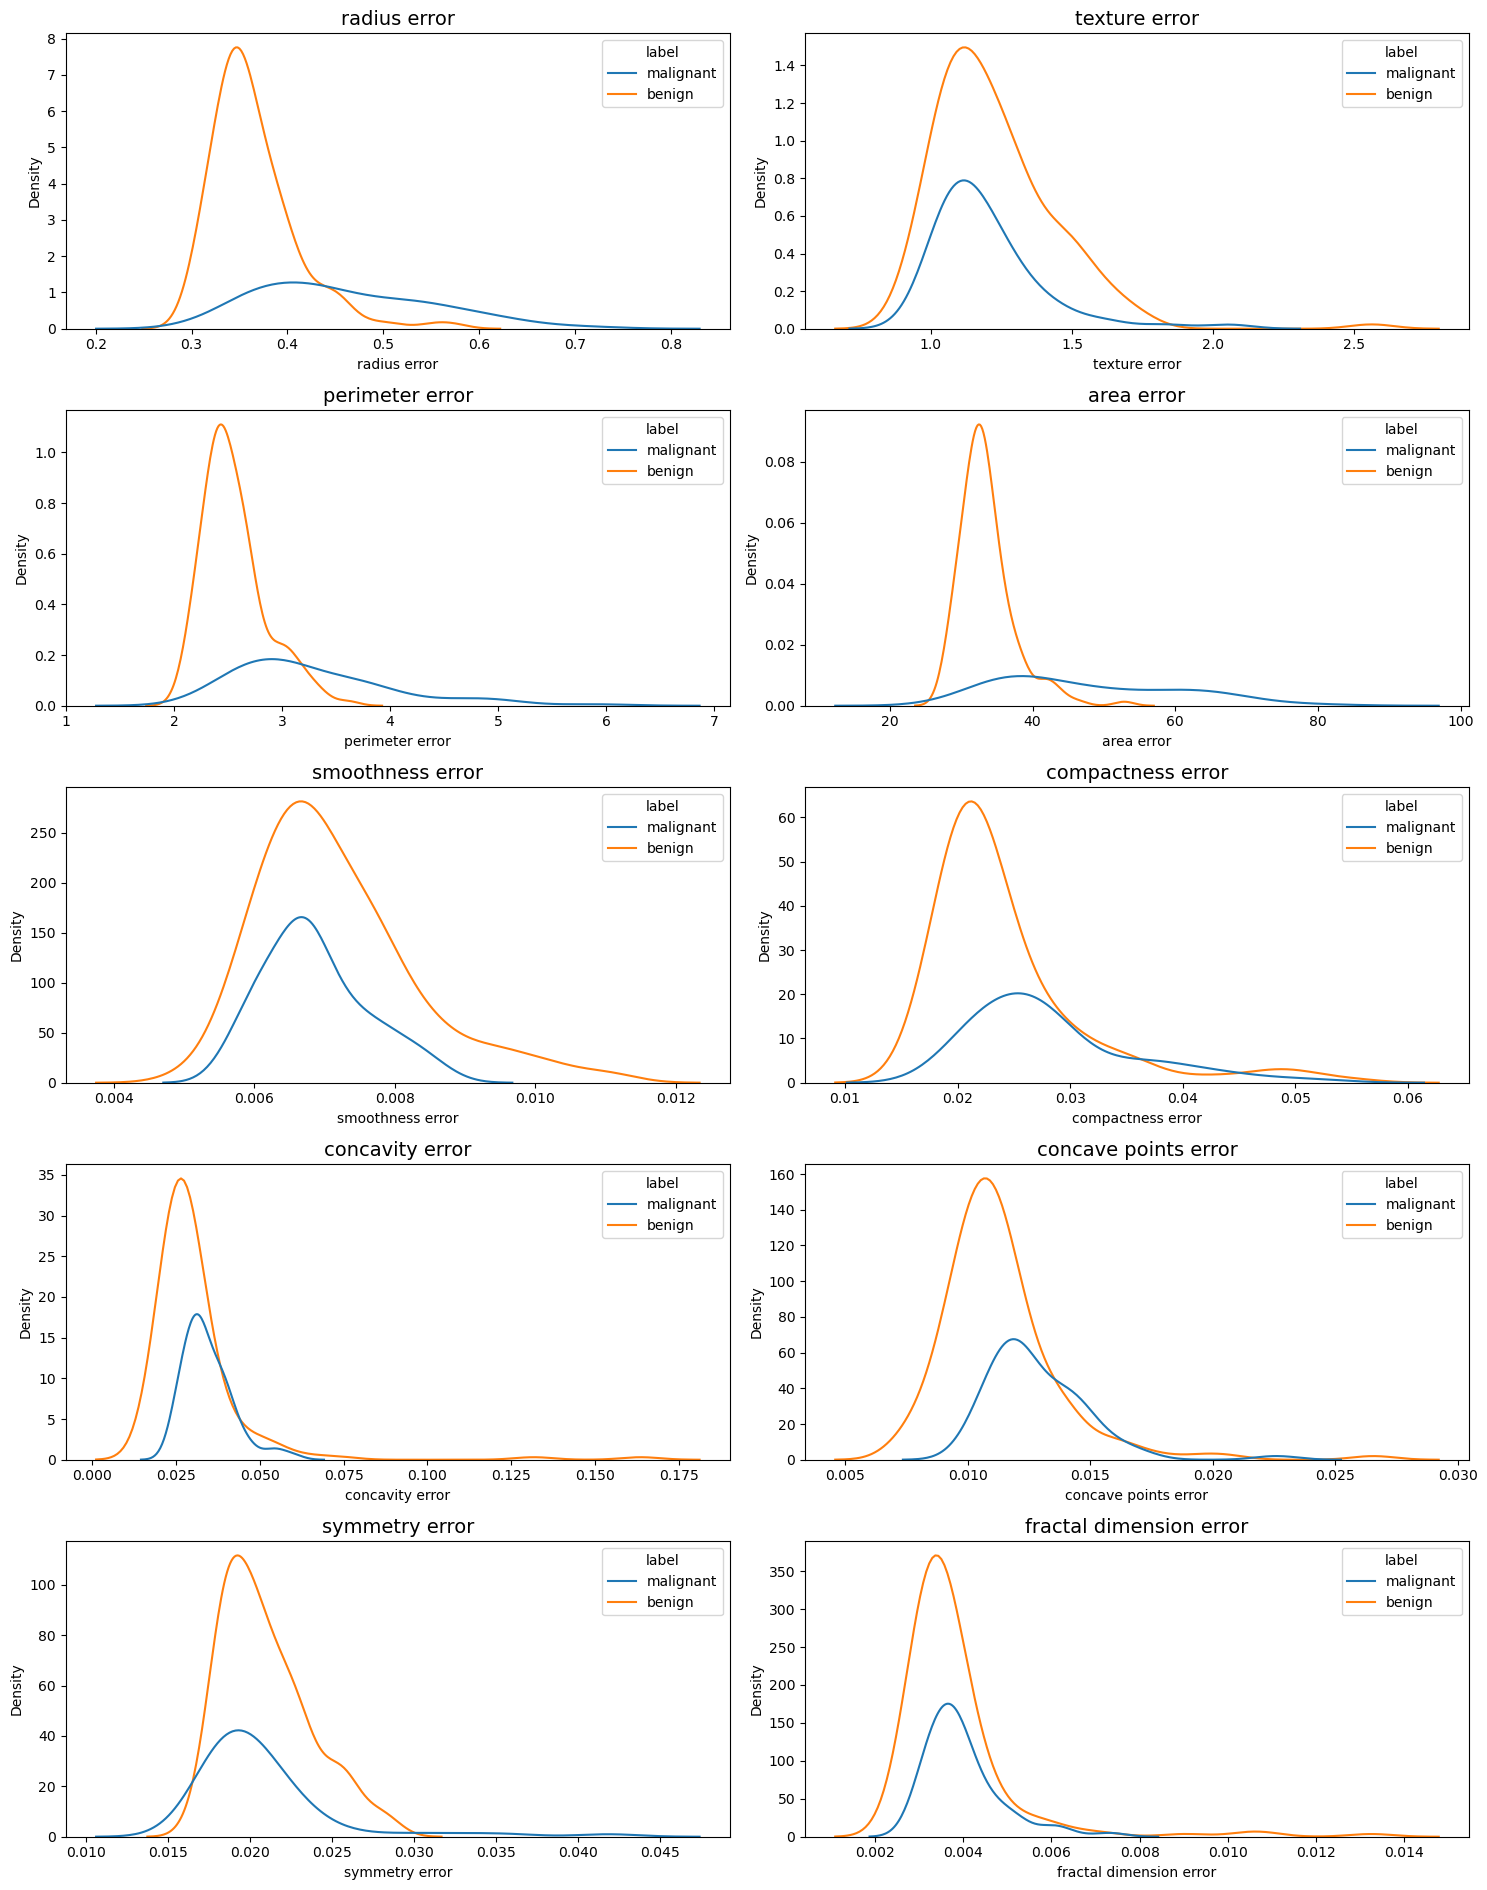

In [15]:
# Create subplots of mean features
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the figure size as needed
legend_handles = []

# Plotting the subplots
for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    ax = sns.kdeplot(data=df, x=v, hue="label", ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(v, fontsize=14)  # Adjust title font size as needed
    
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

#### Outlier analysis with violinplots

**Using violinplots and stripplots**

NOTE: Dots refer to the defintion of a statistical outlier where $\hat{x} ± 1.5 * IQR$


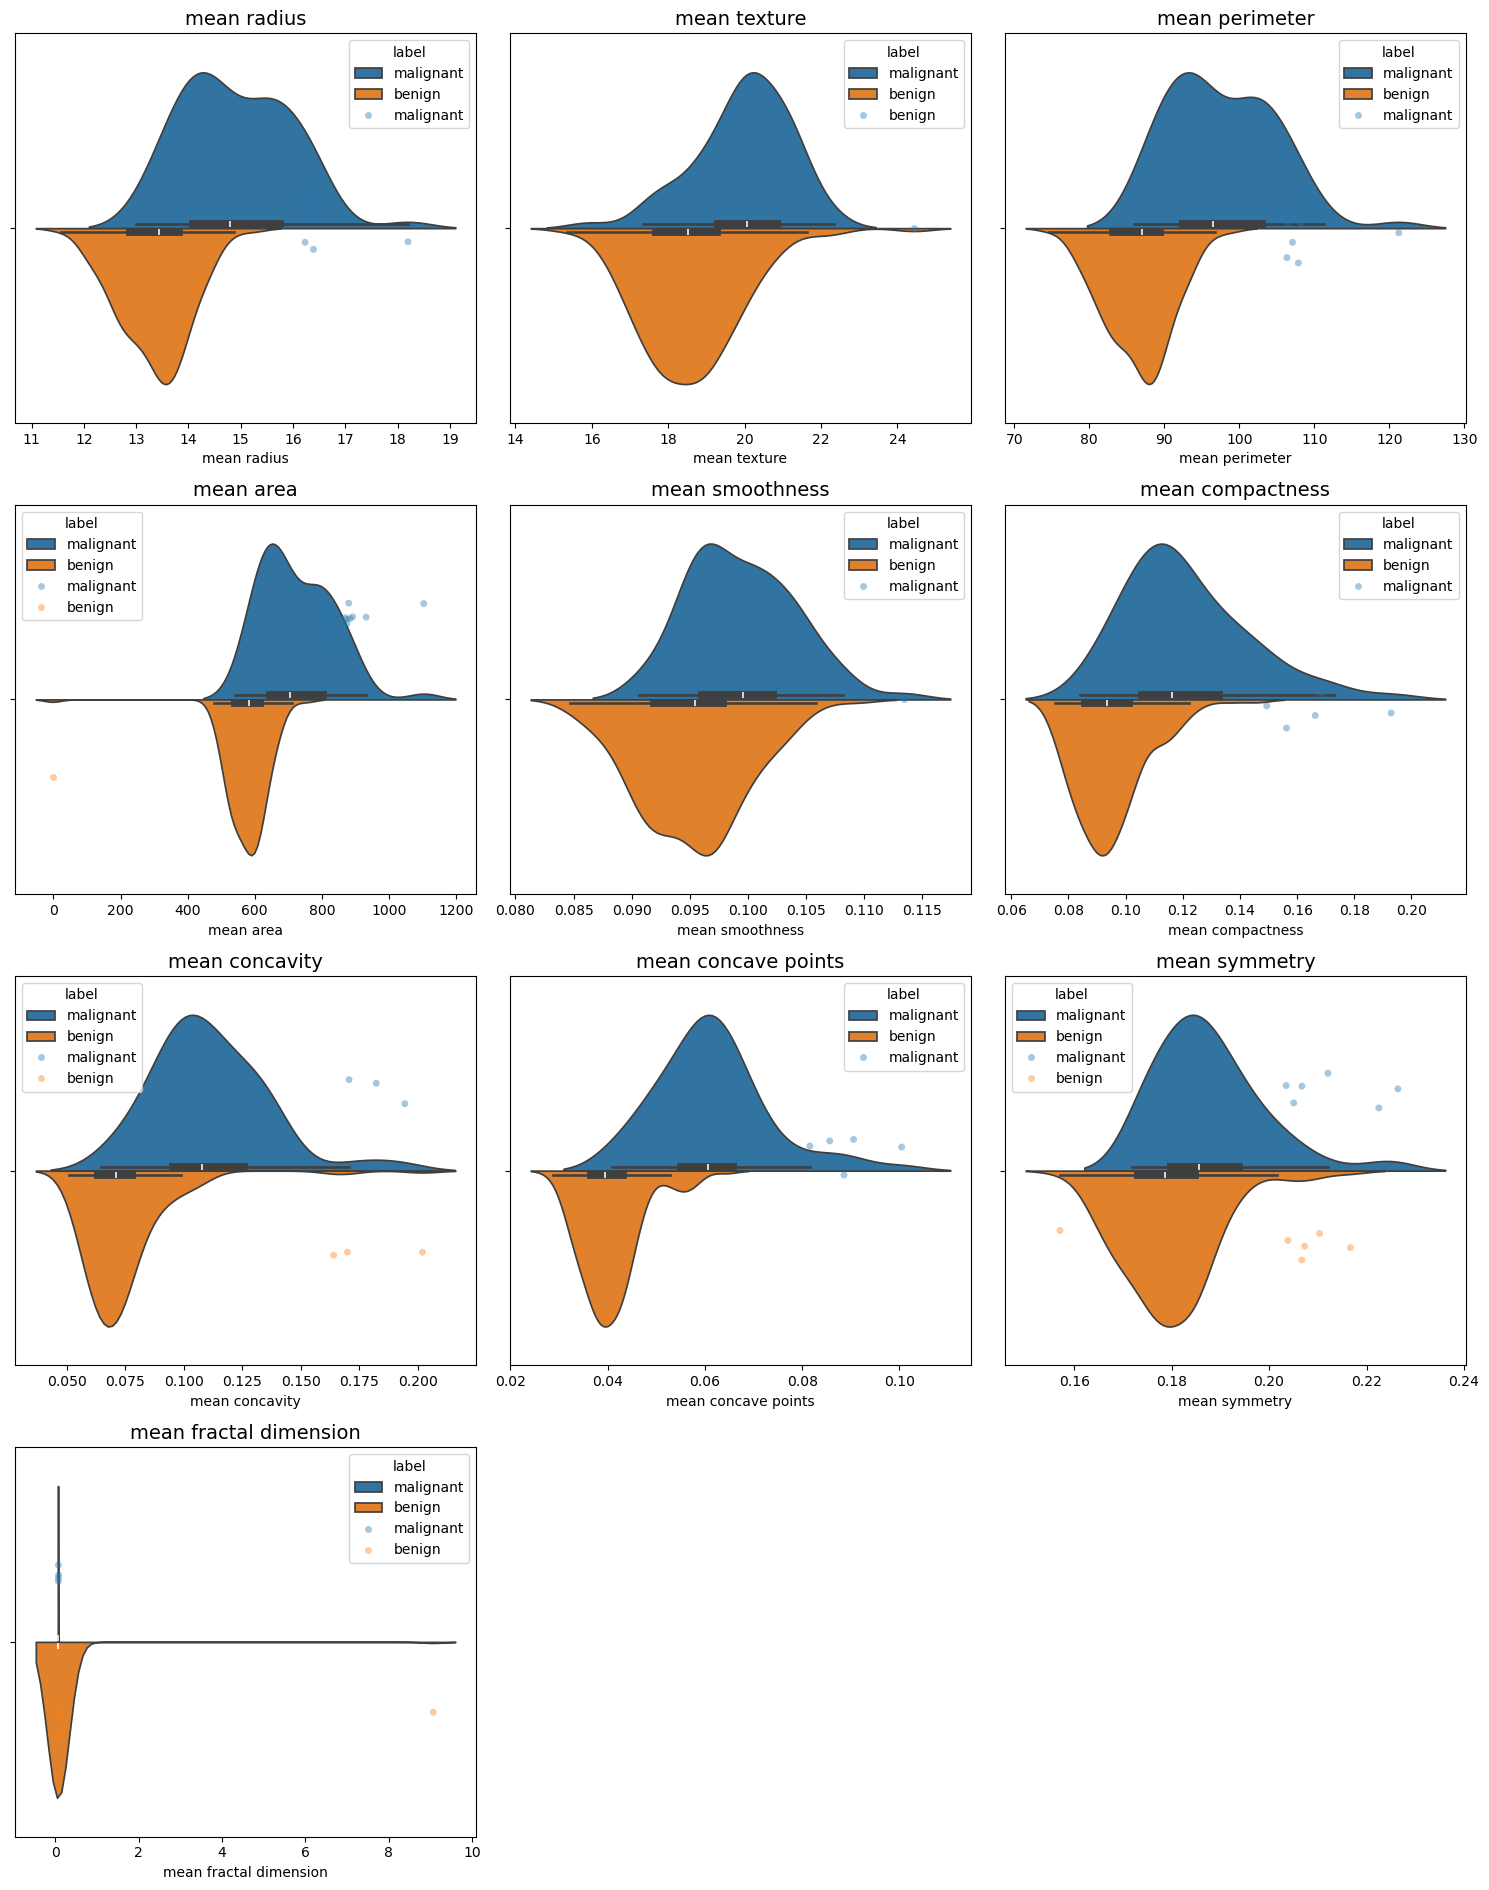

In [16]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()


This plots the violinplots of both malignant and bening values w.r.t each outlier values for the mean measurement features. We will use the distributions to serve as guidance with the outliers to "eyeball" *unreasonable values*.

We make the following observations:

- There is one data point at mean radius that greatly impacts the skew of the distribution for malignant cases
- There is one data point at mean perimeter that greatly impacts the skew of the distribution for malignant cases 
- There is one data point in mean area that greatly impacts the skew of the distribution for benign cases
- There are multiple values in mean concavity that greatly impacts the skew of the distribution for both cases
- There is an extereme outlier in mean fractal dimension for benign cases

In [17]:
# Removing outliers of the "mean" feautures by setting these as np.nan
# We will manually remove problematic outliers and replace these to be with np.nan to be imputed in step 2
df["mean radius"] = df["mean radius"].apply(lambda x: np.nan if x > 18 else x)
df["mean perimeter"] = df["mean perimeter"].apply(lambda x: np.nan if x > 120 else x)
df["mean area"] = df["mean area"].apply(lambda x: np.nan if x <= 200 else x)
df["mean concavity"] = df["mean concavity"].apply(lambda x: np.nan if x > 0.170 else x)
df["mean fractal dimension"] = df["mean fractal dimension"].apply(lambda x: np.nan if x > 1 else x)

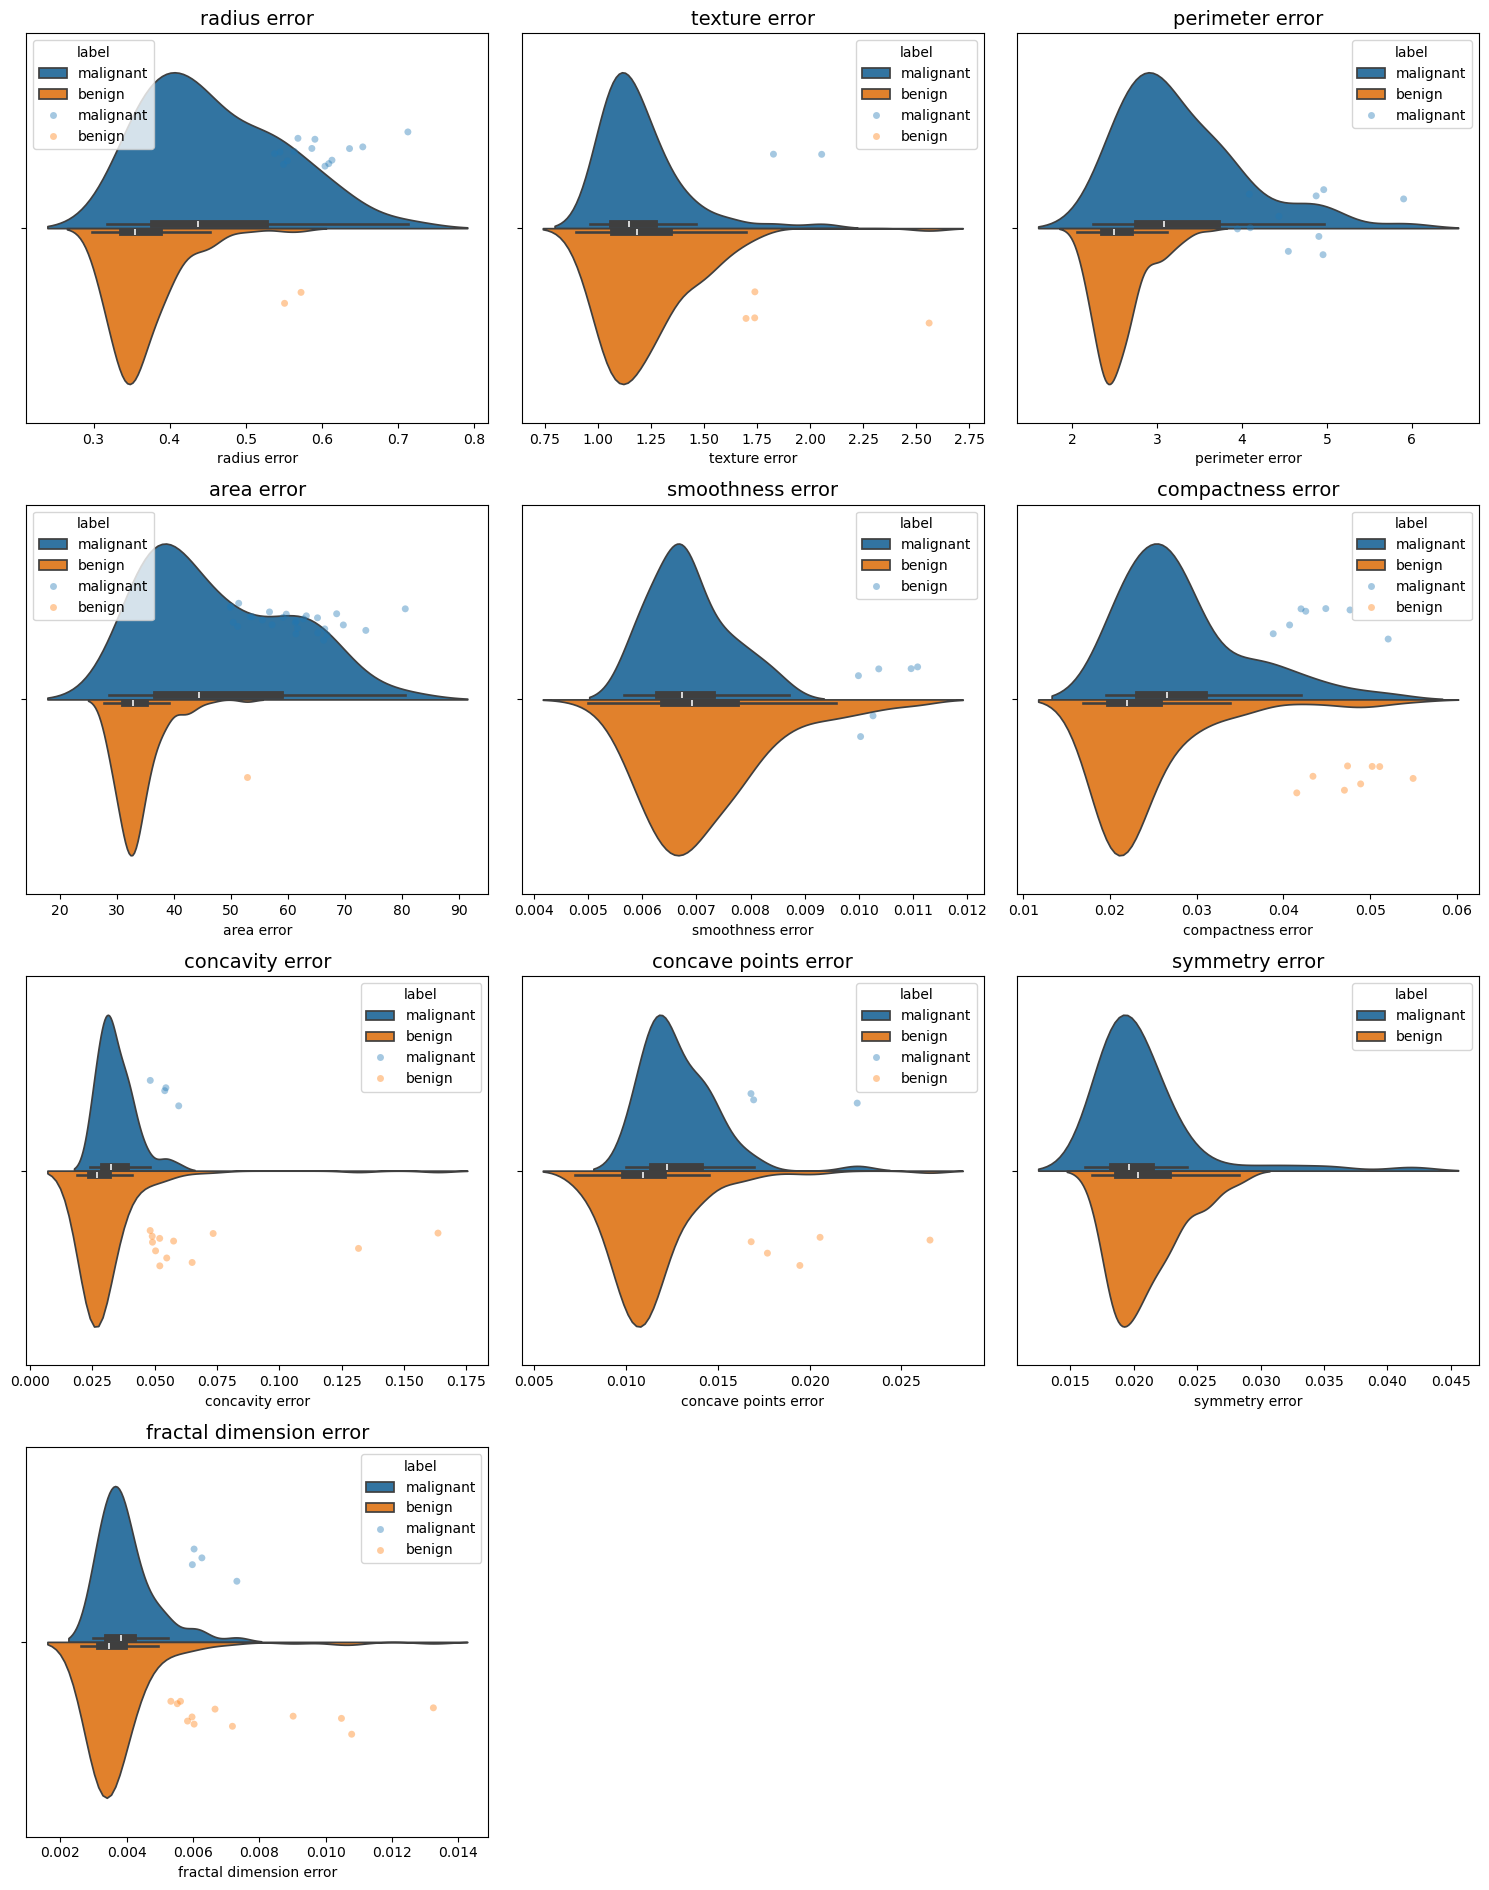

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

We make the following observations:

- There are extreme outliers heavily skewing texture error for both cases
- There are extreme outliers in concavity error for benign cases that impact the distribution's skewness
- There are extreme outleirs for concave points error for both cases that impact the distribution's skewness
- There is some outliers for fractal dimension error for benign cases that that impact the distribution's skewness 

In [19]:
# Removing outliers of the "error" features
# We will manually remove problematic outliers and replace these to be with np.nan to be imputed in step 2
df['texture error'] = df['texture error'].apply(lambda x: np.nan if x > 1.75 else x)
df['concavity error'] = df['concavity error'].apply(lambda x: np.nan if x > 0.1 else x)
df['concave points error'] = df['concave points error'].apply(lambda x: np.nan if x > 0.022 else x)
df['fractal dimension error'] = df['fractal dimension error'].apply(lambda x: np.nan if x > 0.008 else x)

#### Visualization after Data Cleaning and Outlier Analysis

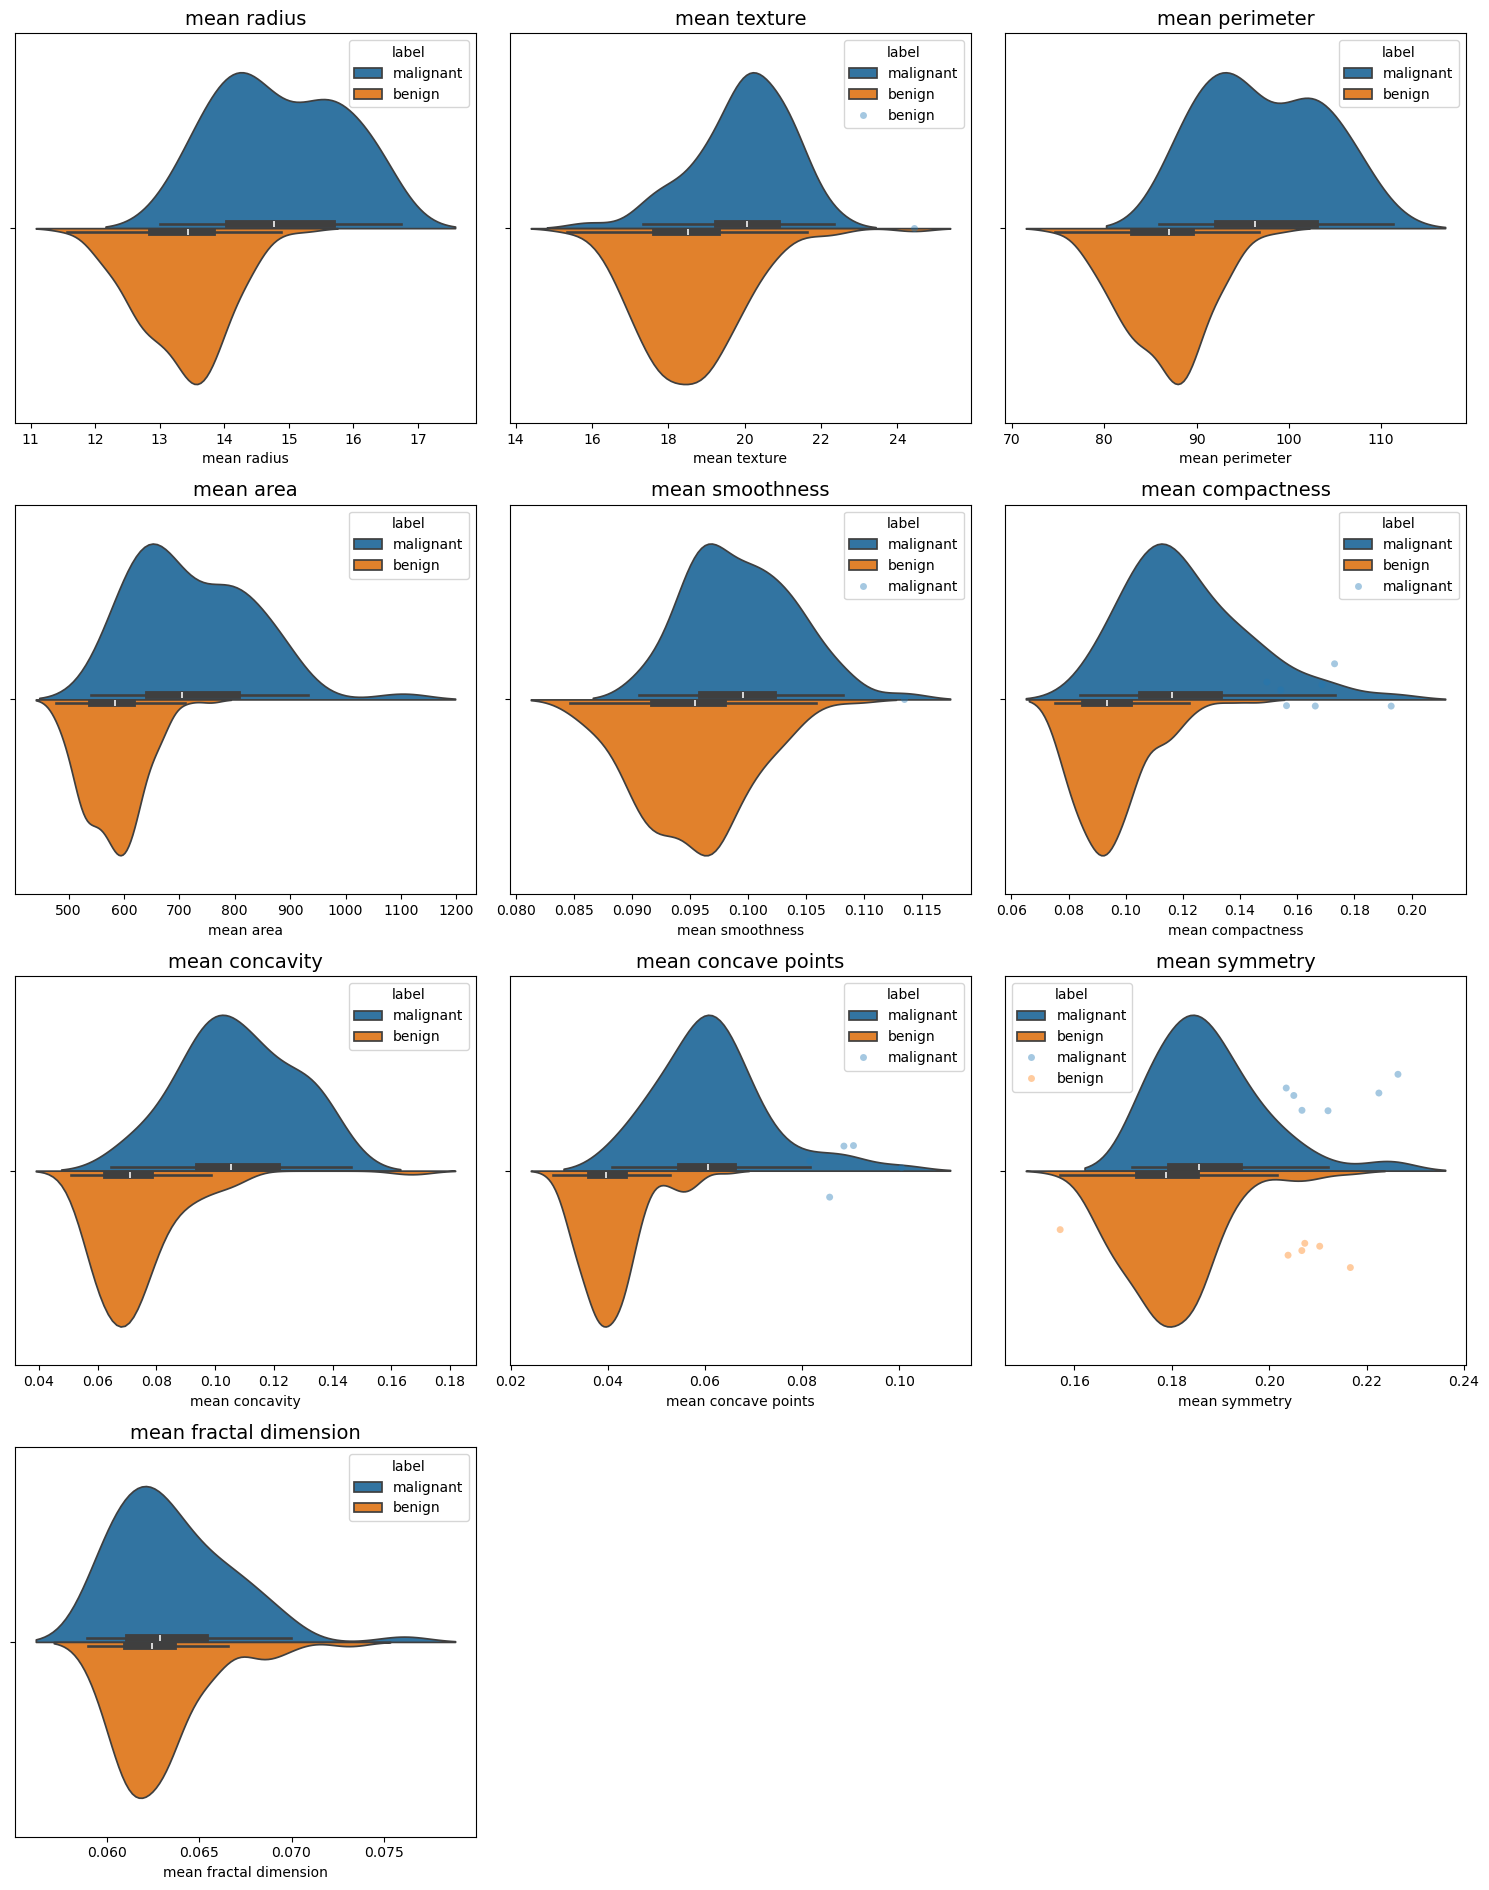

In [20]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

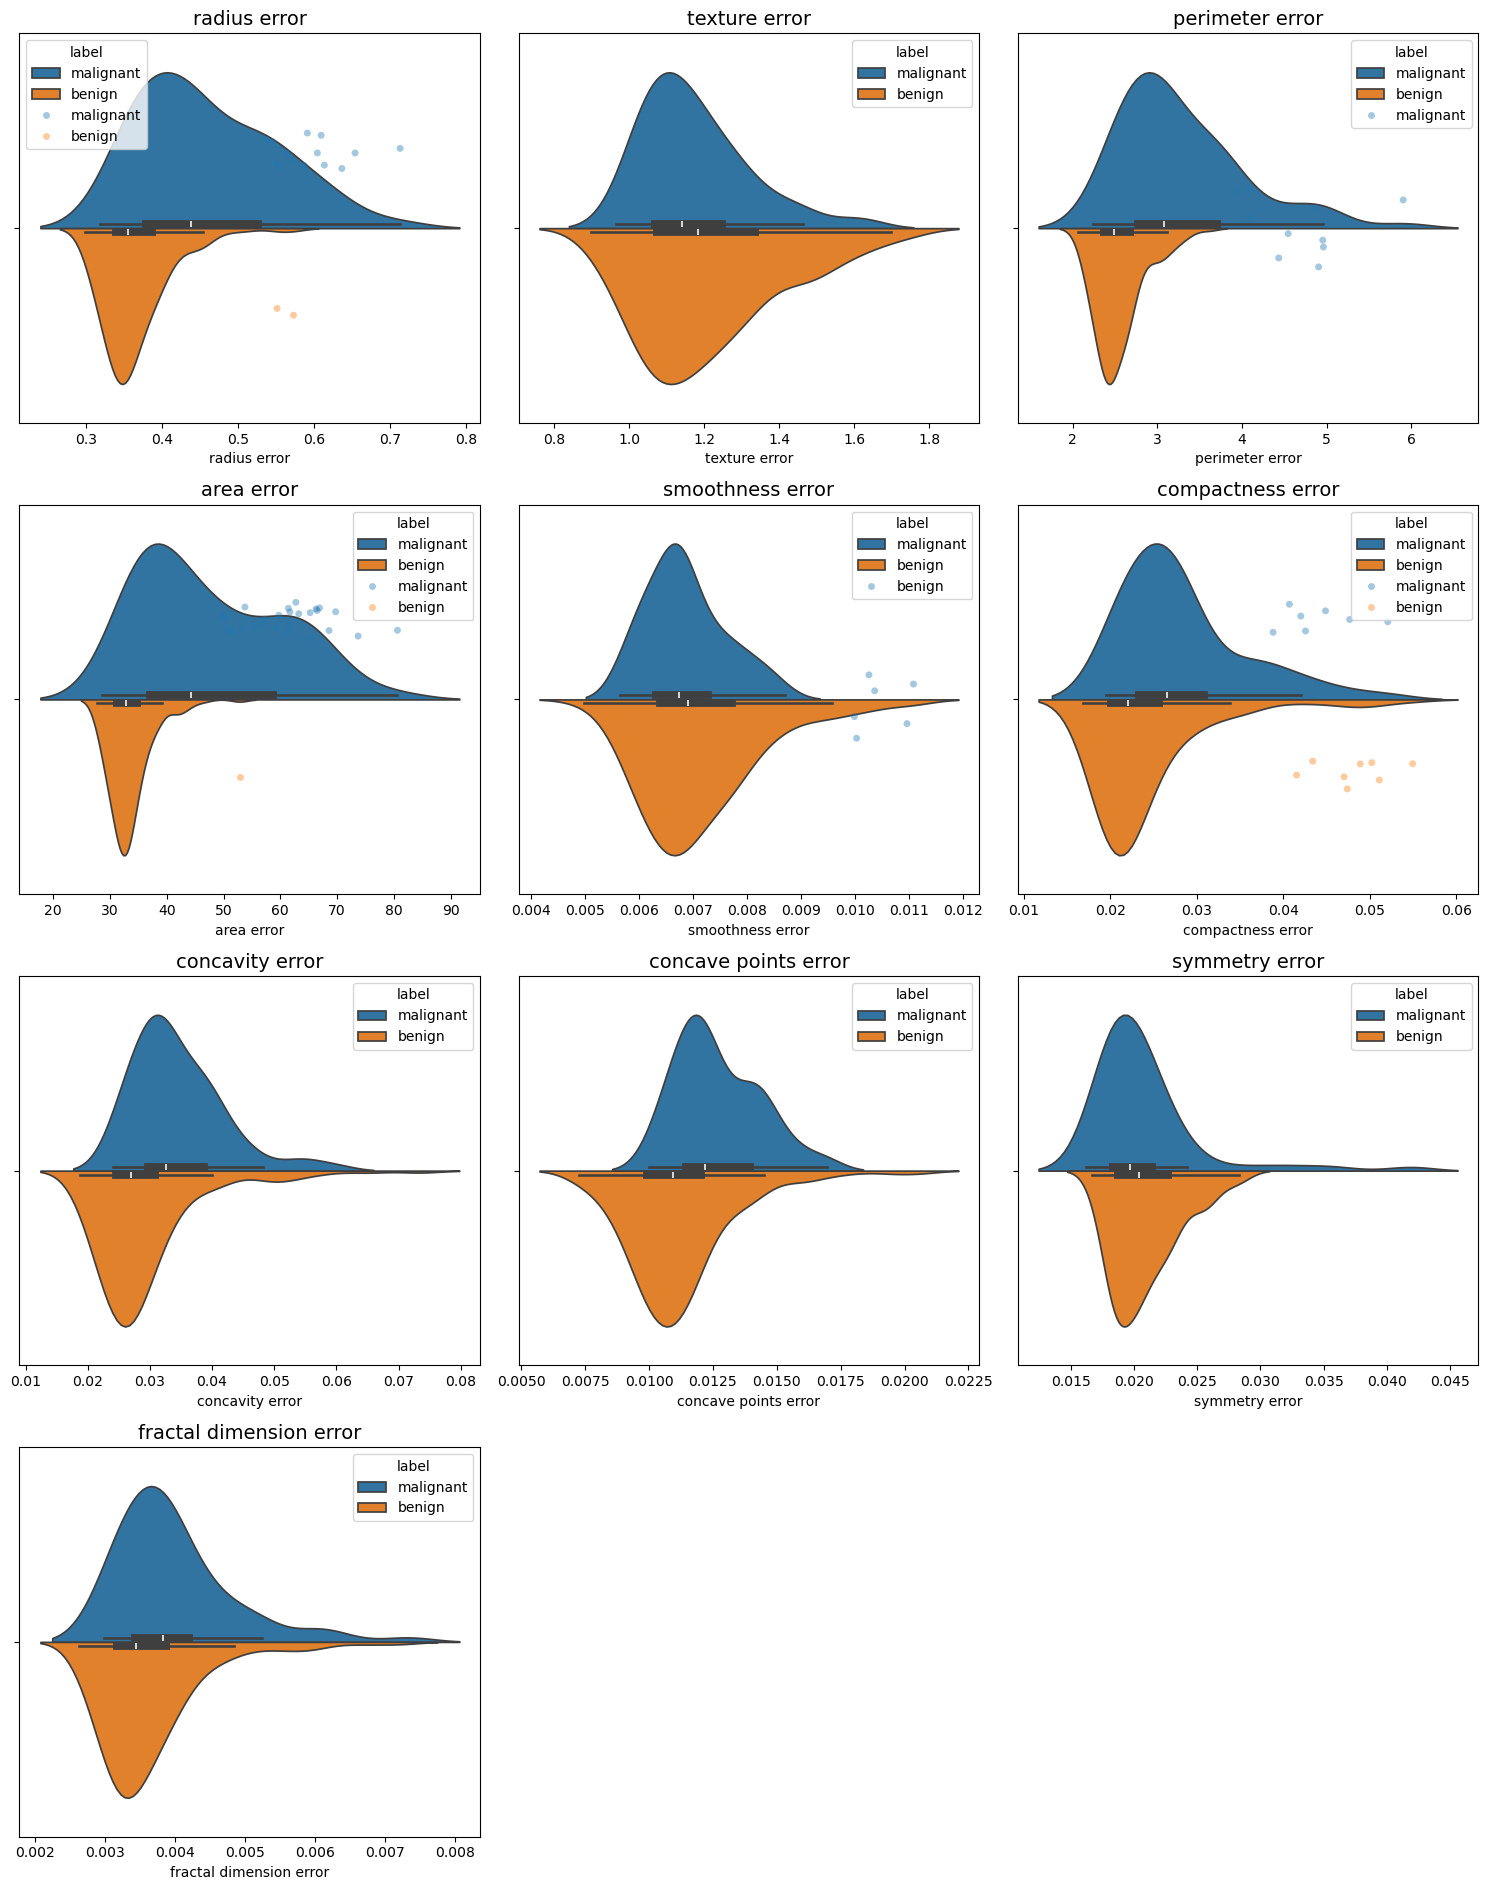

In [21]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

In [22]:
### Final step -> transform target into proper binary values
df['label'] = df['label'].apply(lambda x: 1 if x == 'malignant' else 0)

In [23]:
df.dtypes

label                        int64
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
dtype: object

## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

In [29]:
# Split the data into appropriate train, validaiton and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target], test_size=0.2, random_state=random_seed, stratify=df[target])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [30]:
# Defining the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

In [ ]:
# Simple baseline model for validation data
baseline_predictions = np.random.choice([0, 1], size=len(y_val))

In [25]:
# Some helpful code that you can use if you wish (or not)

from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

In [26]:
# Your code here

## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

In [27]:
# Answer here

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

In [28]:
# Your code here

### 3.3 Final results

From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

In [29]:
# Answer here

## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [30]:
# Your code here

### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [31]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [32]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of N mean values (used to populate constant features with)
    n1, n2: index numbers of features that change
              that is, which features xx and yy represent, from the set of N features
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [33]:
# Your code here

### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

In [34]:
# Answer here